<a href="https://colab.research.google.com/github/cheveanrichards/VAE_Pytorch/blob/main/Generating_Anime_Faces_VAE_with_Pytorch_Lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'another-anime-face-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F923624%2F2154267%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240429%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240429T203122Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9b24707731ec45854316cad4b5ac2dea3846d5bc2b52d6945884ec027476bc813030e7885d38c575e8a9a19827b1468f8b5365c6fa57390612492866398558673747a4d58de6d05f201d70b937900493c688e4363e3c15e1f56f0a715cdda543fb0c606214b7ab9f1fab76f854aaae237db53571e0050a7174c7d7319711f4db5aa7463c2d52f114ea4b8164a5394be057d9deb137bcc55bb7b7060b2299faf99109263614ecee635151e2b4a00ed16a0b7cf153b5eff2c6b1805b7c936cc7aa2b988608cae916d8699a7c7d592d59427d6752de41304b9bfe8c65ee60456333b11fd242abf83cc30c12d75c31f11b96a96592e079c06e480f34d77e876fc3a5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import torch
import pytorch_lightning as PL
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch import nn
from tqdm import tqdm
import torch.nn.functional as F
import os
from torchmetrics import Accuracy, F1Score

In [ ]:
def load_images(folder_path, img_size = 64):
    X = []
    transform = transforms.Resize((img_size, img_size))
    for img_name in tqdm(os.listdir(folder_path)):
        try:
            img_path = os.path.join(folder_path, img_name)
            img_tensor = torchvision.io.read_image(img_path)
            img_tensor = transform(img_tensor)
            X.append(img_tensor / 255.0)
            if len(X) > 100000:
                break
        except:
            pass
    return X
dataset = load_images(r'/kaggle/input/another-anime-face-dataset/animefaces256cleaner')
dataset[0].shape

  0%|          | 0/92219 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 92219/92219 [08:35<00:00, 178.92it/s]


torch.Size([3, 64, 64])

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset, shuffle = True, batch_size = 64, num_workers = 3)
a = next(iter(train_loader))
a.shape

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([64, 3, 64, 64])

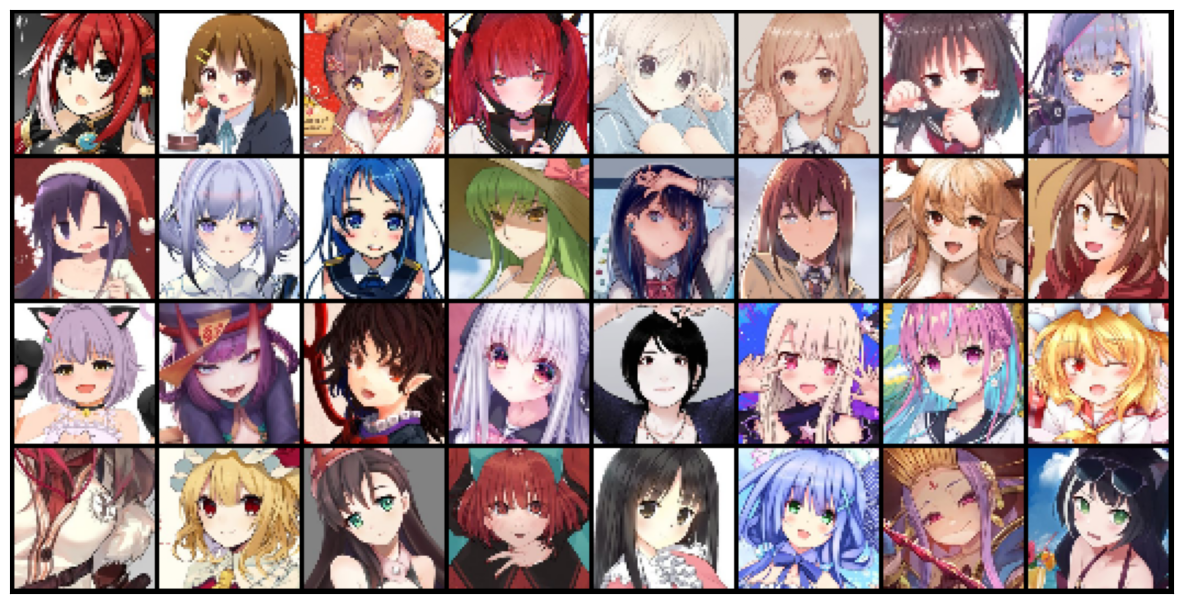

In [ ]:
def show_images(images, N = 32):
    plt.figure(figsize = (15, 15))
    grid = torchvision.utils.make_grid(images[:N])
    grid = grid.numpy().transpose((1, 2, 0))
    plt.imshow(grid)
    plt.xticks([])
    plt.yticks([])
    plt.show()
show_images(a)

In [ ]:
class VariationalAutoencoder(PL.LightningModule):
    def __init__(self, latent_dim = 64):
        super().__init__()
        self.latent_dim = latent_dim
        self.KL_coef = 0.5
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = (3, 3), stride = 2, padding = 1),
            nn.LeakyReLU(),

            nn.Conv2d(64, 128, kernel_size = (3, 3), stride = 2, padding = 1),
            nn.LeakyReLU(),

            nn.Conv2d(128, 256, kernel_size = (3, 3), stride = 2, padding = 1),
            nn.LeakyReLU(),

            nn.Conv2d(256, 512, kernel_size = (3, 3), stride = 2, padding = 1),
            nn.LeakyReLU(),

            nn.Flatten(),
            nn.Linear(4*4*512, 512),
            nn.LeakyReLU()
        )

        self.get_mean = nn.Linear(512, self.latent_dim)
        self.get_logvar = nn.Linear(512, self.latent_dim)

        self.decoder_linear = nn.Sequential(
            nn.Linear(self.latent_dim, 512),
            nn.LeakyReLU(),

            nn.Linear(512, 4*4*512),
            nn.LeakyReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size = (3, 3), stride = 2, padding = 1, output_padding = 1, bias = False),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size = (3, 3), stride = 2, padding = 1, output_padding = 1, bias = False),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size = (3, 3), stride = 2, padding = 1, output_padding = 1, bias = False),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(64, 3, kernel_size = (3, 3), stride = 2, padding = 1, output_padding = 1, bias = False),
            nn.Sigmoid()
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(self.decoder_linear(x).reshape(-1, 512, 4, 4))

    def sample(self, mean, logvar):
        epsilon = torch.randn_like(mean)
        return mean + torch.exp(0.5 * logvar) * epsilon

    def forward(self, x):
        out = self.encode(x)
        mean, logvar = self.get_mean(out), self.get_logvar(out)
        z = self.sample(mean, logvar)
        out = self.decode(z)
        return out, mean, logvar

    def vae_loss(self, fake_images, real_images, z_mean, z_log_var):
        reconstruction_loss = torch.mean(torch.square(real_images))
        kl_loss = -self.KL_coef * torch.mean(1 + z_log_var - torch.square(z_mean) - torch.exp(z_log_var))
        total_loss = reconstruction_loss + kl_loss
        return kl_loss, reconstruction_loss, total_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr = 0.0003)

    def training_step(self, batch, batch_idx):
        x = batch
        x_recon, mu, log_var = self(x)
        recon_loss = F.binary_cross_entropy(x_recon.view(x.size(0), -1), x.view(x.size(0), -1), reduction='sum')
        kl_divergence = -self.KL_coef * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + kl_divergence
        self.log_dict({'KL_Loss' : kl_divergence, 'reconstruction_loss' : recon_loss, 'total_loss':loss}, prog_bar = True, on_epoch = True)
        return loss

In [ ]:
model = VariationalAutoencoder()
trainer = PL.Trainer(accelerator = 'gpu', max_epochs = 300)

In [ ]:
trainer.fit(model, train_loader)

In [ ]:
z = torch.randn(64, 64)
y_pred = model.decode(z)
print(y_pred.shape)
show_images(y_pred, 16)